<a href="https://www.kaggle.com/code/pathompongmuangthong/my-very-dumb-neural-network-keras?scriptVersionId=118219314" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predict/Classification of user's rating given review text

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb
import re

import warnings
warnings.filterwarnings("ignore")

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [2]:
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
%matplotlib inline

## Load The Dataset

In [3]:
df = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv',
                usecols=['review_text', 'rating'])

## Quick Lookup

In [4]:
df.head()

,rating,review_text
0,5,This is a special book. It started slow for ab...
1,3,Recommended by Don Katz. Avail for free in Dec...
2,3,"A fun, fast paced science fiction thriller. I ..."
3,0,Recommended reading to understand what is goin...
4,4,"I really enjoyed this book, and there is a lot..."


In [5]:
print(df['review_text'].apply(lambda x: len(x.split(' '))).sum())

176535573


<AxesSubplot:>

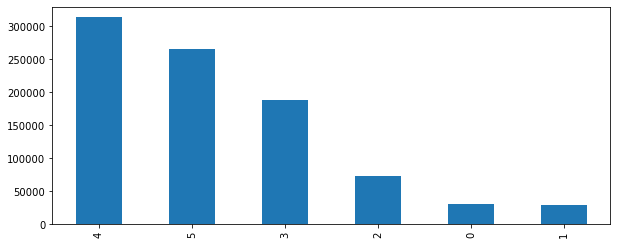

In [6]:
plt.figure(figsize=(10,4))
df.rating.value_counts().plot(kind='bar')

The rating label is imbalanced. <br/>
How can I handle this? hmm... <br/>
 - Using weighted RMSE loss?
 - Using scikit-learn's `LogisticRegression` class with weighting?

## Text Preprocessing

In [7]:
stopwords = stopwords.words('english')

In [8]:
def preprocess_desc(text_col):
    preprocessed_descs = []
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tag_pattern = re.compile('@(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    for sentence in tqdm(text_col.values):
        if sentence is np.nan:
            preprocessed_descs.append(sent.lower().strip())
            continue
        else:
            sent = url_pattern.sub('', sentence)
            sent = tag_pattern.sub('', sent)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
            preprocessed_descs.append(sent.lower().strip())
    return preprocessed_descs

In [9]:
df = df.assign(pre_text = preprocess_desc(df['review_text']))

100%|██████████| 900000/900000 [06:54<00:00, 2173.60it/s]


In [10]:
print(df['pre_text'].apply(lambda x: len(x.split(' '))).sum())

97059902


In [11]:
df.head()

,rating,review_text,pre_text
0,5,This is a special book. It started slow for ab...,this special book it started slow first third ...
1,3,Recommended by Don Katz. Avail for free in Dec...,recommended don katz avail free december
2,3,"A fun, fast paced science fiction thriller. I ...",a fun fast paced science fiction thriller i re...
3,0,Recommended reading to understand what is goin...,recommended reading understand going middle am...
4,4,"I really enjoyed this book, and there is a lot...",i really enjoyed book lot recommend it drag li...


## Tokenizing

In [12]:
!pip install tensorflow-gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

  Preparing metadata (setup.py) ... - done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 36, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-bo6scgjz/tensorflow-gpu_c66a2773f68e4fc9aa239eee7109b7a5/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Ru

In [13]:
reviews = df['pre_text'].tolist()
#ratings = df['rating'].tolist()
ratings = [rating-1 for rating in df['rating'].tolist()]

In [14]:
# Preprocessing
# Convert the ratings to one-hot encoding
#labels = tf.keras.utils.to_categorical(ratings, num_classes=6)
labels = tf.keras.utils.to_categorical(ratings, num_classes=5)

In [15]:
labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [16]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
sequence = tokenizer.texts_to_sequences(reviews)

In [17]:
# Pad the sequences to a fixed length
sequence = pad_sequences(sequence, maxlen=100)

In [18]:
sequence

array([[ 7725,    14,     4, ...,  6952,   146,    55],
       [    0,     0,     0, ..., 18233,   538,  4334],
       [ 2535,   607,    12, ...,  1132,   146,    55],
       ...,
       [  284,  1568,   369, ...,   156,  2771,   925],
       [52355,  7924,  4672, ...,   269,     2,     5],
       [    0,     0,     0, ...,   387,  3251,     5]], dtype=int32)

## Splitting

In [19]:
# Splitting the data
split = 0.8
split_index = int(len(sequence) * split)
# Train split
train_data = sequence[:split_index]
train_labels = labels[:split_index]
# Test split
test_data = sequence[split_index:]
test_labels = labels[split_index:]

In [20]:
train_data.shape

(720000, 100)

In [21]:
test_data.shape

(180000, 100)

In [22]:
train_labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## Define Weighted RMSE loss

In [23]:
# Calculate weight for each class
num_classes = 5
weights = np.zeros(num_classes)
for c in range(num_classes):
    class_data = train_labels[train_labels[:, c] == 1]
    weights[c] = 1.0 / (np.sum(class_data) / float(train_labels.shape[0]))
weights = weights / np.sum(weights)

In [24]:
weights

array([0.57413502, 0.22781972, 0.08766856, 0.05324444, 0.05713225])

In [25]:
def weighted_rmse(y_true, y_pred, weights):
    # Calculate the mean squared error for each sample
    sample_mse = tf.math.square(y_true - y_pred)
    
    # Apply the weights to the mean squared error
    weighted_mse = tf.math.multiply(sample_mse, weights)
    
    # Calculate the mean of the weighted mean squared error
    mean_weighted_mse = tf.reduce_mean(weighted_mse)
    
    # Return the root mean squared error
    return tf.math.sqrt(mean_weighted_mse)

## Building The Model

In [26]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-02-04 17:42:22.641863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 17:42:22.646177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 17:42:22.646878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [27]:
# Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    mode='min',
    restore_best_weights=True)

In [28]:
# Building the model
model = keras.Sequential([
    keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                           output_dim=100,
                           input_length=100),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

2023-02-04 17:42:23.368155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 17:42:23.368546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 17:42:23.369314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 17:42:23.369970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          28817100  
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 30,105,809
Trainable params: 30,105,809
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compile the model
'''
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

model.compile(optimizer='adam', 
              loss=lambda y_true, y_pred: weighted_rmse(y_true, y_pred, weights), 
              metrics=['accuracy'])

'''
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              sample_weight_mode="temporal")
'''

'\nmodel.compile(optimizer=\'adam\', \n              loss=\'categorical_crossentropy\', \n              metrics=[\'accuracy\'], \n              sample_weight_mode="temporal")\n'

In [31]:
# Training the model

history = model.fit(train_data, train_labels, 
                    epochs=100, batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

'''
history = model.fit(train_data, train_labels, 
                    epochs=10, batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping])
'''

2023-02-04 17:42:27.274471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
18000/18000 [==============================] - 165s 9ms/step - loss: 0.1101 - accuracy: 0.5183 - val_loss: 0.1070 - val_accuracy: 0.5348
Epoch 2/100
18000/18000 [==============================] - 163s 9ms/step - loss: 0.1011 - accuracy: 0.6036 - val_loss: 0.1100 - val_accuracy: 0.5142
Epoch 3/100
18000/18000 [==============================] - 164s 9ms/step - loss: 0.0872 - accuracy: 0.7048 - val_loss: 0.1160 - val_accuracy: 0.5019


'\nhistory = model.fit(train_data, train_labels, \n                    epochs=10, batch_size=32, \n                    validation_split=0.2,\n                    callbacks=[early_stopping])\n'

In [32]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy: ', test_acc)

5625/5625 [==============================] - 8s 1ms/step - loss: 0.1054 - accuracy: 0.5394
Test accuracy:  0.5394166707992554


## Plot History

In [33]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

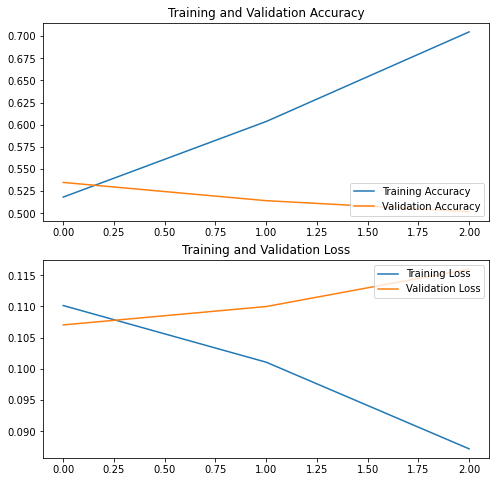

In [34]:
plot_history(history)

## Predicts on unseen data

In [35]:
dfTest = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv',
                usecols=['review_id', 'review_text'])

In [36]:
dfTest.head()

,review_id,review_text
0,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...
1,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink..."
2,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...
3,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...
4,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...


In [37]:
dfTest = dfTest.assign(pre_text = preprocess_desc(dfTest['review_text']))

100%|██████████| 478033/478033 [03:45<00:00, 2124.03it/s]


In [38]:
dfTest.head()

,review_id,review_text,pre_text
0,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,spoiler alert this definitely one favorites am...
1,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",spoiler alert you drink i huge fan coffee i bu...
2,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,roar one favorite characters under never sky i...
3,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,spoiler alert if feel like travelling europe m...
4,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,3 5 stars i read enjoyed first two novels seri...


In [39]:
unseen_text = dfTest['pre_text'].tolist()

In [40]:
# Predictions on unseen data
unseen_sequence = tokenizer.texts_to_sequences(unseen_text)
unseen_sequence = pad_sequences(unseen_sequence, maxlen=100)
predictions = model.predict(unseen_sequence)
predictions = np.argmax(predictions, axis=1)

In [41]:
predictions.shape

(478033,)

In [42]:
print("Predictions:", predictions)

Predictions: [3 3 4 ... 4 4 2]


In [43]:
# Create submission dataframe
submission = pd.DataFrame({'review_id': dfTest['review_id'],
                           'rating': predictions})

In [44]:
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,3
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,3
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,4
478029,0b7f352e58caf0fd1f961e98ef04e89c,4
478030,9b19eff33ddb14e9e68fca2e90379e46,4
478031,8be463fed78f0da63e964706f710332b,4


In [45]:
# Export submission file for submit to competition
submission.to_csv("submission.csv", index=False)

## My note o.O
- While doing this I just keep forgeting that there are imbalance data, ... but nvm :'>
    - 0.22921 | My dumb feedforward NN do their best :'<
- Now I use weigted RMSE loss (Yep, I do care about data imbalance now(?))
    - 0.21617 | My dumb dumb still dumb :p

![Nyan Cat](https://i0.wp.com/www.printmag.com/wp-content/uploads/2021/02/4cbe8d_f1ed2800a49649848102c68fc5a66e53mv2.gif?resize=476%2C280&ssl=1)

In [46]:
# Plz sending love to my dumb dumb neural network ★♥︎☀︎